In [2]:
using Gurobi, JuMP, DataFrames, CSV
using Statistics
using MLBase
using JuMP, Ipopt
using StatsBase
using Juniper
using Shuffle

In [21]:
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame)

# Only keep rows where sold ==1
df = df[df[!,"sold"] .== 1, :];

#Keep the rows where price is between 5th and 95th percentile
df = df[df[!,"sales_price"] .> quantile(df[!,"sales_price"], 0.05), :]
df = df[df[!,"sales_price"] .< quantile(df[!,"sales_price"], 0.95), :];

#Drop the column sold
df = df[:, Not(:sold)]

#Define target variable 
y = df[!,"sales_price"]
X= df[:, Not(:sales_price)];

X

36665×112 DataFrame
   Row │ dated    height   inscribed  signed   stamped  width    aspect_ratio  ⋯
       │ Float64  Float64  Float64    Float64  Float64  Float64  Float64       ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     0.0    40.94        1.0      1.0      0.0    15.55          2.63  ⋯
     2 │     0.0    41.73        1.0      1.0      0.0    25.39          1.64
     3 │     0.0    47.24        1.0      1.0      0.0    22.36          2.11
     4 │     0.0    50.79        0.0      1.0      0.0    27.76          1.83
     5 │     0.0    52.76        1.0      1.0      0.0    27.56          1.91  ⋯
     6 │     0.0    23.82        0.0      1.0      0.0    47.24          0.5
     7 │     0.0    35.43        0.0      1.0      0.0    37.87          0.94
     8 │     0.0    20.87        0.0      0.0      0.0    23.03          0.91
     9 │     0.0    19.09        1.0      1.0      0.0    22.24          0.86  ⋯
    10 │     0.0    32.48        1.0      1.0      0.0    19.29          1.68
    11 │     0.0    25.98        0.0      1.0      0.0    25.59          1.02
   ⋮   │    ⋮        ⋮         ⋮         ⋮        ⋮        ⋮          ⋮        ⋱
 36656 │     0.0    18.9         0.0      1.0      0.0    30.71          0.62
 36657 │     1.0    30.71        0.0      1.0      0.0    18.9           1.62  ⋯
 36658 │     1.0    12.6         0.0      1.0      0.0    18.5           0.68
 36659 │     1.0    19.02        0.0      1.0      0.0    12.99          1.46
 36660 │     1.0    20.87        0.0      1.0      0.0    19.29          1.08
 36661 │     1.0    24.41        0.0      1.0      0.0    18.11          1.35  ⋯
 36662 │     1.0    32.28        0.0      0.0      0.0    24.41          1.32
 36663 │     0.0    33.86        0.0      1.0      0.0    29.53          1.15
 36664 │     0.0    10.71        0.0      0.0      0.0    22.36          0.48
 36665 │     0.0     8.66        0.0      0.0      0.0    13.78          0.63  ⋯
                                              105 columns and 36644 rows omitted

In [22]:
seed = 15095
(X_train, y_train), (X_test, y_test) =  IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8); #further splitting train set into train and validation sets

In [23]:
function corrPair(threshold)
    n,p = size(X_train)
    pairs = []
    for i=1:p
        for j=i+1:p
            if abs(cor(X_train[:,i], X_train[:,j])) > threshold
                append!(pairs, [(i,j)])
            end
        end
    end
    return collect(pairs)
end

HC_pairs = corrPair(0.7)
HC_pairs

10-element Vector{Any}:
 (2, 8)
 (6, 8)
 (9, 10)
 (25, 79)
 (29, 82)
 (44, 97)
 (58, 80)
 (76, 94)
 (100, 103)
 (107, 108)

In [24]:
#Which are these variables?
for i in corrPair(0.7)
    println(names(X_train)[i[1]], " ", names(X_train)[i[2]])
end

height area
width area
low_estimate high_estimate
Egon Schiele Austria
Fernando Botero Colombia
Le Pho Vietnam
René Magritte Belgium
Zhu (ju Ming) Ming Taiwan
Christies Sothebys
painting paper


In [25]:
function compute_mse(X, y, ß)
    n,p = size(X)
    return sum((Matrix(X)*ß .- y).^2)/n
end;

In [54]:
function optimize(X_training, y_training)
    n, p = size(X_training)
    #£ = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 250.0]

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 90) #Set a timelimit of 90 seconds (60 seconds previously)

    @variable(model, ß[i=1:p])
    @variable(model, z[i=1:p], Bin)
    @variable(model, a[i=1:p]>=0)
    
    M=100000000
    k=10

    #@constraint(model, binary[i=1:p], -M*z[i]≤ß[i])
    #@constraint(model, binary2[i=1:p], ß[i]≤M*z[i])
    #@constraint(model, corr[(i,j) in HC_pairs], z[i] + z[j] ≤ 1)
    #@constraint(model, lim, sum(z) ≤ 15)
    #@constraint(model, absoluteValue, å .≥ ß)
    #@constraint(model, absoluteValue1, å .≥ -ß)

    #Constraints for sparsity - Big M
    @constraint(model, [j=1:p], ß[j] <= M*z[j])
    @constraint(model, [j=1:p], -M*z[j] <= ß[j])
    
    #Constraint for sparsity 2 - Limiting number of non zero components
    #@constraint(model, sum(z[j] for j=1:p) <= k)
    @constraint(model, sum(z) <= 10)


    #Constraint for features with high collinearities
    @constraint(model, [e=1:length(HC_pairs)], (z[HC_pairs[e][1]] + z[HC_pairs[e][2]]) <= 1)

    #Insert constraints - Linearize norm 1
    @constraint(model,[j=1:p], ß[j]<=a[j])
    @constraint(model,[j=1:p], -ß[j]<=a[j])
     
    lambda = 7
    best = Inf
    
    #= for £ in lambdas
        @objective(model, Min, 1/n * sum((y_training - (Matrix(X_training) * ß)).^2) + £ * sum(å))
        optimize!(model)
        score = compute_mse(Matrix(X_valid), y_valid, JuMP.value.(ß))
        println("Lambda: ", £, " MSE: ", score)
        if score < best
            best = score 
            lambda = £
        end
    end  =#
 
    @objective(model, Min, 1/n * sum(((y_training) - (Matrix(X_training) * ß)).^2) + lambda * sum(a))
    
    optimize!(model)

    return JuMP.value.(ß), lambda, JuMP.value.(z)
end

optimize (generic function with 1 method)

In [55]:
betas, best_lambda, zetas=optimize(X_train, y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 459 rows, 336 columns and 1028 nonzeros
Model fingerprint: 0xb13a45e7
Model has 2051 quadratic objective terms
Variable types: 224 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [7e+00, 1e+12]
  QObjective range [1e-04, 2e+12]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 7.414203e+11
Presolve time: 0.00s
Presolved: 459 rows, 336 columns, 1028 nonzeros
Presolved model has 2051 quadratic objective terms
Variable types: 224 continuous, 112 inte

([5679.779065110636, -87.22671482318269, 6840.402078383815, 29410.522153330283, 0.0, 577.5035417716135, 19046.54710185791, 0.0, 1.1443015237083, 0.04115069983876385  …  0.0, 0.0, 0.0, 0.0, 34524.24886098989, 0.0, 0.0, 0.0, 0.0, 0.0], 7, [1.0, 8.722671482318269e-7, 1.0, 1.0, -0.0, 5.775035417716136e-6, 1.0, -0.0, 1.1443015237083e-8, 4.115069983876385e-10  …  -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0])

In [56]:
#Calculate R2 score
function r2_score(y_true, y_pred)
    SS_res = sum((y_true .- y_pred).^2)
    SS_tot = sum((y_true .- mean(y_true)).^2)
    return 1 - SS_res/SS_tot
end

r2_score(y_test, Matrix(X_test) * betas)

0.7919856260492548

In [57]:
#Which is the non zero coefficient?
for i in 1:length(betas)
    if betas[i]!= 0
        println(betas[i], " ", names(X_train)[i])
    end
end

5679.779065110636 dated
-87.22671482318269 height
6840.402078383815 inscribed
29410.522153330283 signed
577.5035417716135 width
19046.54710185791 aspect_ratio
1.1443015237083 low_estimate
0.04115069983876385 high_estimate
19683.65563697521 artist_second_tier
48461.92950157237 artist_third_tier
78369.51735353633 China
33063.656384484406 Christies
34524.24886098989 painting


In [58]:
sum(betas.!=0)

13

In [59]:
sum(zetas.!=0)

13

# Looks like Estimate Low alone can achieve an R2 of 0.76, it is just multiplying the low estimate by 1.3423. Let's try it all over again but without these estimate variables. 

In [155]:
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame)

# Only keep rows where sold ==1
df = df[df[!,"sold"] .== 1, :];

#Drop the "low_estimate" and "high_estimate" columns
df = df[:, Not(:low_estimate)]
df = df[:, Not(:high_estimate)]
df = df[:, Not(:sold)]

#Keep the rows where price is between 5th and 95th percentile
df = df[df[!,"sales_price"] .> quantile(df[!,"sales_price"], 0.05), :]
df = df[df[!,"sales_price"] .< quantile(df[!,"sales_price"], 0.95), :];

#Define target variable 
y = df[!,"sales_price"]
X= df[:, Not(:sales_price)];

seed = 15095
(X2, y2), (X_test, y_test) = IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8) #setting apart test set
(X_train, y_train), (X_valid, y_valid) =  IAI.split_data(:classification, X2, y2, seed=seed, train_proportion=0.8); #further splitting train set into train and validation sets

function corrPair(threshold)
    n,p = size(X_train)
    pairs = []
    for i=1:p
        for j=i+1:p
            if abs(cor(X_train[:,i], X_train[:,j])) > threshold
                append!(pairs, [(i,j)])
            end
        end
    end
    return collect(pairs)
end

HC_pairs = corrPair(0.7)

8-element Vector{Any}:
 (2, 8)
 (6, 8)
 (23, 77)
 (27, 80)
 (56, 78)
 (74, 92)
 (98, 101)
 (105, 106)

In [172]:
function optimize2(X_training, y_training)
    n, p = size(X_training)

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 120) #Set a timelimit of 60 seconds

    @variable(model, ß[i=1:p])
    @variable(model, z[i=1:p], binary=true)
    @variable(model, å[i=1:p]>=0)
    
    M=100000000

    @constraint(model, binary[i=1:p], -M*z[i]≤ß[i])
    @constraint(model, binary2[i=1:p], ß[i]≤M*z[i])
    @constraint(model, corr[(i,j) in HC_pairs], z[i] + z[j] ≤ 1)
    @constraint(model, lim, sum(z) ≤ 25)
    @constraint(model, absoluteValue, å .≥ ß)
    @constraint(model, absoluteValue1, å .≥ -ß)

    lambda = 7
    best = 100000000000
 
    @objective(model, Min, sum(((y_training) - (Matrix(X_training) * ß)).^2) + lambda * sum(å))
    
    optimize!(model)

    return JuMP.value.(ß), lambda
end

optimize2 (generic function with 1 method)

In [173]:
betas, best_lambda=optimize2(X_train, y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 449 rows, 330 columns and 1006 nonzeros
Model fingerprint: 0xd07c9143
Model has 1822 quadratic objective terms
Variable types: 220 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [7e+00, 6e+13]
  QObjective range [4e+00, 5e+11]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.224347e+16
Presolve time: 0.00s
Presolved: 449 rows, 330 columns, 1006 nonzeros
Presolved model has 1822 quadratic objective terms
Variable types: 220 continuous, 110 in

([0.0, 0.0, 0.0, 0.0, 0.0, 3164.742892905001, 0.0, 0.0, 432359.16655160487, -2.9103830456733704e-11  …  0.0, 0.0, 0.0, 0.0, 279978.26585591177, 0.0, 0.0, 0.0, 200016.98681021814, 0.0], 7)

In [174]:
r2_score(y_test, Matrix(X_test) * betas)

0.07312473435333489

In [171]:
r2_score(y_train, Matrix(X_train) * betas)

0.07824213248317413

In [170]:
#Which is the non zero coefficient?
for i in 1:length(betas)
    if betas[i] != 0
        println(names(X_train)[i])
    end
end

height
aspect_ratio
Alfred Sisley
Andy Warhol
Bernard Buffet
Chu Teh Chun (zhu Dequn)
Chu Teh-Chun
Claude Monet
Emil Nolde
Fernand Léger
Gerhard Richter
Henry Moore
Jean Michel Basquiat
Lucio Fontana
Maqbool Fida Husain
Max Ernst
Paul Klee
René Magritte
Serge Poliakoff
Wu Guanzhong
Zao Wou-Ki
Zhang Daqian
Austria
China
England
France
Germany
Indonesia
Italy
Netherlands
Russia
Spain
Switzerland
USA
United States of America
Vietnam
other_country
Christies
Villa Grisebach Auktionen
paper
photograph


# Holistic Logistic Regression

In [7]:
seed = 15095

#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame);
#get column names
show(names(df))


["dated", "height", "inscribed", "signed", "stamped", "width", "aspect_ratio", "area", "sold", "sales_price", "low_estimate", "high_estimate", "Alberto Giacometti", "Alexej Von Jawlensky", "Alfred Sisley", "Alighiero Boetti", "Andy Warhol", "Bernard Buffet", "Camille Jacob Pissarro", "Chu Teh Chun (zhu Dequn)", "Chu Teh-Chun", "Cindy Sherman", "Claude Monet", "Cy Twombly", "Damien Hirst", "Edgar Degas", "Egon Schiele", "Emil Nolde", "Eugène Louis Boudin", "Fernand Léger", "Fernando Botero", "Francis Newton Souza", "Francis Picabia", "Gerhard Richter", "Giorgio De Chirico", "Henri Emile Benoit Matisse", "Henry Moore", "Ivan Konstantinovich Aivazovsky", "Jean Dubuffet", "Jean Michel Basquiat", "Joan Miró", "Josef Albers", "Kees Van Dongen", "Keith Haring", "Laurence Stephen Lowry", "Le Pho", "Lucio Fontana", "Maqbool Fida Husain", "Marc Chagall", "Maurice De Vlaminck", "Maurice Utrillo", "Max Ernst", "Pablo Ruiz Picasso", "Paul Klee", "Pierre Auguste Renoir", "Pierre Bonnard", "Pu Ru", "

In [8]:
features_lr= ["dated", "height", "inscribed", "signed" , "stamped", "width", "aspect_ratio", "area", "sold", "sales_price", "low_estimate", "high_estimate"]

12-element Vector{String}:
 "dated"
 "height"
 "inscribed"
 "signed"
 "stamped"
 "width"
 "aspect_ratio"
 "area"
 "sold"
 "sales_price"
 "low_estimate"
 "high_estimate"

In [9]:
df= df[:, features_lr]

41533×12 DataFrame
   Row │ dated    height   inscribed  signed   stamped  width    aspect_ratio  ⋯
       │ Float64  Float64  Float64    Float64  Float64  Float64  Float64       ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     0.0    33.66        1.0      1.0      0.0    16.93          1.99  ⋯
     2 │     0.0    13.58        1.0      1.0      0.0    10.43          1.3
     3 │     0.0    40.94        1.0      1.0      0.0    15.55          2.63
     4 │     0.0    13.19        1.0      1.0      0.0    16.73          0.79
     5 │     0.0     9.45        1.0      1.0      0.0    10.63          0.89  ⋯
     6 │     0.0    55.91        1.0      1.0      0.0    28.54          1.96
     7 │     0.0    41.73        1.0      1.0      0.0    25.39          1.64
     8 │     0.0    47.24        1.0      1.0      0.0    22.36          2.11
     9 │     0.0    50.79        0.0      1.0      0.0    27.76          1.83  ⋯
    10 │     0.0    52.76        1.0      1.0      0.0    27.56          1.91
    11 │     0.0    36.73        1.0      1.0      0.0    21.38          1.72
   ⋮   │    ⋮        ⋮         ⋮         ⋮        ⋮        ⋮          ⋮        ⋱
 41524 │     0.0    18.9         0.0      1.0      0.0    30.71          0.62
 41525 │     1.0    30.71        0.0      1.0      0.0    18.9           1.62  ⋯
 41526 │     1.0    12.6         0.0      1.0      0.0    18.5           0.68
 41527 │     1.0    19.02        0.0      1.0      0.0    12.99          1.46
 41528 │     1.0    20.87        0.0      1.0      0.0    19.29          1.08
 41529 │     1.0    24.41        0.0      1.0      0.0    18.11          1.35  ⋯
 41530 │     1.0    32.28        0.0      0.0      0.0    24.41          1.32
 41531 │     0.0    33.86        0.0      1.0      0.0    29.53          1.15
 41532 │     0.0    10.71        0.0      0.0      0.0    22.36          0.48
 41533 │     0.0     8.66        0.0      0.0      0.0    13.78          0.63  ⋯
                                                5 columns and 41512 rows omitted

In [10]:
df_sold = df[df[!,"sold"] .== 1, :]
df_unsold = df[df[!,"sold"] .== 0, :]

#Change the 0's for -1's in the "sold" column
df_unsold[!,"sold"] = df_unsold[!,"sold"] .- 1

df_sold_limited = df_sold[sample(1:nrow(df_sold), 862, replace=false), :] #select only 862 sold rows to get a balanced dataset

df_lr = vcat(df_unsold, df_sold_limited) #concatenate the two dataframes

#Distribution of sold column - Check it worked
countmap(df_lr[!,"sold"])

Dict{Int64, Int64} with 2 entries:
  -1 => 862
  1  => 862

In [11]:
#Define target variable 
y = df_lr[!,"sold"]
X= df_lr[:, Not(:sales_price)];
X= X[:, Not(:sold)];

seed = 15095

(X_train, y_train), (X_test, y_test) =  IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8); 

In [12]:
#Distribution in y_train
countmap(y_train)

Dict{Int64, Int64} with 2 entries:
  -1 => 690
  1  => 690

In [13]:
countmap(y_test)

Dict{Int64, Int64} with 2 entries:
  -1 => 172
  1  => 172

In [14]:
function optimize3(X_training, y_training)

    n, p = size(X_training)

    #nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
    #minlp_solver = optimizer_with_attributes(Juniper.Optimizer, "nl_solver"=>nl_solver)
    #model = Model(minlp_solver)
    model = Model(Ipopt.Optimizer)

    @variable(model, ß[i=1:p])
    @variable(model, ß_0)
    @variable(model, 1>=z[i=1:p]>=0)
    
    M=1000
    k=5
    lambda = 10

    #Constraints for sparsity - Big M
    @NLconstraint(model, [j=1:p], ß[j] <= M*z[j])
    @NLconstraint(model, [j=1:p], -M*z[j] <= ß[j])
    
    #Constraint for sparsity 2 - Limiting number of non zero components
    @NLconstraint(model, sum(z[j] for j=1:p) <= k)

    #Constraint for features with high collinearities
    #@constraint(model, [j=1:length(HC_pairs)], (z[HC_pairs[j][1]] + z[HC_pairs[j][2]]) <= 1)
     
    #@NLobjective(model, Min, sum(log(1 + exp(-y_training[i]*(sum(X[i,j]*ß[j] for j=1:p)+ß_0))) for i=1:n))
    @NLobjective(model, Min, sum(log(1 + exp(-y_training[i]*(sum(X[i,j]*ß[j] for j=1:p)+ß_0)+ lambda * sum(abs(ß[j]) for j=1:p))) for i=1:n))
    
    optimize!(model)

    return JuMP.value.(ß), JuMP.value.(ß_0), lambda
end

optimize3 (generic function with 1 method)

In [16]:
betas, beta_0, best_lambda=optimize3(X_train, y_train)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       50
Number of nonzeros in Lagrangian Hessian.............:       66

Total number of variables............................:       21
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       21
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       21

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.5654311e+02 0.00e+00 9.80e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

([-1.093904619075013, -6.532381670620903, 1.180053593939187, -0.5476599950852536, 0.6298667086198524, -5.616655174829442, -1.7945721554925123, 0.1078357596572023, 5.744722971720606e-5, -2.8904701015971566e-5], 219.71803324230297, 10)

In [17]:
#Predictions - Binary Classification from logistic regression
y_pred = 1 ./ (1 .+ exp.(-(Matrix(X_test)*betas .+ beta_0)))
show(y_pred);

[1.1787816943123017e-46, 9.020555752438606e-182, 1.730661110434871e-38, 4.107402400920663e-14, 3.784855062120171e-26, 5.320584986150502e-7, 3.721397216338885e-32, 0.9999999999755007, 0.2634441045808342, 1.0, 1.4469122022216225e-33, 4.4674813507456873e-10, 0.0, 4.660344023639866e-92, 2.839150183770661e-54, 1.0, 3.61457885094762e-30, 4.008802560345693e-25, 1.0, 1.0, 1.0, 2.538599571217001e-11, 1.0, 0.9999999999999971, 2.981327952515549e-56, 6.489854987483134e-27, 5.908256730933405e-24, 1.0, 1.0, 1.0, 1.023095155500963e-32, 1.0, 0.9999999998023055, 1.2793070687540008e-11, 1.6206843800962533e-52, 1.0, 0.9999999999960578, 6.0826698711350316e-27, 0.858028526694667, 0.9979101684993926, 4.675587890876341e-34, 6.584565651728277e-19, 1.5912745831414877e-8, 5.8182522948074e-19, 7.152224116734193e-20, 9.525762981019256e-28, 5.127012352349884e-32, 6.173531803675816e-63, 1.137848281209769e-56, 2.8706136196043997e-52, 0.0013057983054835809, 3.9759690394196645e-19, 3.820553526352258e-12, 1.0, 1.0, 5.3

In [18]:
#Convert to 0's and 1's
y_pred = ifelse.(y_pred .> 0.5, 1, -1)

#Accuracy
accuracy = sum(y_pred .== y_test) / length(y_test)

#Confusion Matrix
confusion_matrix = MLBase.countmap(zip(y_pred, y_test))


Dict{Tuple{Int64, Int64}, Int64} with 4 entries:
  (1, -1)  => 62
  (1, 1)   => 95
  (-1, -1) => 110
  (-1, 1)  => 77

In [19]:
accuracy

0.5959302325581395

# Optimal Prescriptive Tree

In [290]:
seed = 15095
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame);

#Keep the rows where the low estimate is between 0 and 250000 -> 80% of the unsold artwork is in this range
df = df[df[!,"high_estimate"] .< 250000, :];

#Keep only the rows where Christies sold the artwork
#df = df[df[!,"Christies"] .== 1, :];

#Keep rows where the sales price is at most twice the high estimate
df = df[df[!,"sales_price"] .<= 2*df[!,"high_estimate"], :];

#Keep only rows where the sales price is less than 500,000
#df = df[df[!,"sales_price"] .< 500000, :];

df_sold = df[df[!,"sold"] .== 1, :]
df_unsold = df[df[!,"sold"] .== 0, :];

df_sold_limited = df_sold[sample(1:nrow(df_sold), 636, replace=false), :] #select only some sold rows to get a balanced dataset 

df_opt = vcat(df_unsold, df_sold_limited) #concatenate the two dataframes

#Distribution of sold column - Check it worked
countmap(df_opt[!,"sold"])

Dict{Int64, Int64} with 2 entries:
  0 => 636
  1 => 636

In [304]:
#write this dataframe to a csv file
#CSV.write("Cleaning/optimalPrescriptiveTree_Pic_China.csv", df_opt)

"Cleaning/optimalPrescriptiveTree_Pic_China.csv"

In [292]:
seed = 12345
X = df_opt[:, Not(:sold)];
#X = X[:, Not(:sales_price)];
X = X[:, Not(:high_estimate)];
X = X[:, Not(:low_estimate)];

y = df_opt.sold #outcome -> sold or not
t = df_opt.high_estimate; #treatments -> prices -> low estimate

In [293]:
(train_X, train_t, train_y), (test_X, test_t, test_y) = IAI.split_data(
    :policy_maximize, X, t, y, train_proportion=0.5, seed=seed);

In [294]:
train_t_discrete = round.(train_t ./ 5000, digits=0) .* 5000 #discretize the prices to the nearest 5k
train_t_discrete;

In [295]:
# Recover real revenues from sales_price
train_y_revenue= train_X.sales_price
test_y_revenue= test_X.sales_price

# Remove sales_price from the data
train_X = train_X[:, Not(:sales_price)]
test_X = test_X[:, Not(:sales_price)];

In [296]:
prescriptive_grid = IAI.GridSearch(
    IAI.OptimalTreePrescriptionMaximizer(
      random_seed=seed,
    ),
    max_depth=4:8,
)
#train_y_revenue = train_y .* train_t #revenue, which is prices times whether the product was purchased or not
IAI.fit!(prescriptive_grid, train_X, train_t_discrete, train_y_revenue)

All Grid Results:

 Row │ max_depth  cp         train_score  valid_score  rank_valid_score
     │ Int64      Float64    Float64      Float64      Int64
─────┼──────────────────────────────────────────────────────────────────
   1 │         4  0.0220601     0.819826   -1.64691e6                 3
   2 │         5  0.0213066     0.823946   -1.76062e6                 5
   3 │         6  0.0175077     0.828982   -1.68633e6                 4
   4 │         7  0.0156452     0.821841   -1.51034e6                 1
   5 │         8  0.0176721     0.81493    -1.52101e6                 2

Best Params:
  cp => 0.01564517189059985
  max_depth => 7

Best Model - Fitted OptimalTreePrescriptionMaximizer:
  1) Split: China < 0.5
    2) Split: Sothebys < 0.5
      3) Split: aspect_ratio < 0.605
        4) Prescribe: 155000.0, 11 points, error 0.0004779
        5) Split: height < 29.23
          6) Prescribe: 235000.0, 181 points, error 0.0003899
          7) Prescribe: 220000.0, 75 points, error 0.0001369
      8) Split: United States of America < 0.5
        9) Prescribe: 165000.0, 82 points, error 0.0006821
        10) Prescribe: 195000.0, 20 points, error 0.0002641
    11) Split: area < 446.7
      12) Split: area < 433.3
        13) Prescribe: 230000.0, 102 points, error 0.0001856
        14) Prescribe: 230000.0, 6 points, error 0.0004251
      15) Prescribe: 200000.0, 159 points, error 0.0003375

In [297]:
t_options = collect(0:5000:250000) #range from min to max in 500 k increments
t_options;

reward_lnr = IAI.NumericClassificationRewardEstimator(
    outcome_estimator=IAI.XGBoostClassifier(num_round=10),
    outcome_insample_num_folds=2,
    reward_estimator=:direct_method,
    estimation_kernel_bandwidth=1,
    random_seed=seed,
)

function get_rewards(reward_lnr, X, t, y, t_options)
  predictions, score = IAI.fit_predict!(reward_lnr, X, t, y, t_options,
                                        outcome_score_criterion=:auc)
  rewards = predictions[:reward]
  for t in t_options
    rewards[!, Symbol(t)] = round.(rewards[!, Symbol(t)] .* t, digits=3)
  end
  rewards, score
end
train_rewards, train_reward_score = get_rewards(reward_lnr, train_X, train_t,
                                                train_y, t_options)
train_rewards;

In [298]:
test_rewards, test_reward_score = get_rewards(reward_lnr, test_X, test_t,
                                              test_y, t_options)
test_rewards;

In [299]:
function evaluate(recommendations, outcomes, actual_revenue)
    n = length(recommendations)
    pred_revenue = [outcomes[i, recommendations[i]] for i in 1:n]
    improvement = mean(pred_revenue .- actual_revenue) / mean(actual_revenue)
  end
  
  # Get revenue observed for test set in reality
  test_revenue_iai = test_y .* test_t;
  test_revenue_r = test_y_revenue;
  

In [300]:
recommendations_pres = Symbol.(round.(Int, IAI.predict(prescriptive_grid, test_X)[1]))
evaluate(recommendations_pres, test_rewards, test_revenue_iai)

1.0912285842997165

In [301]:
recommendations_pres = Symbol.(round.(Int, IAI.predict(prescriptive_grid, test_X)[1]))
evaluate(recommendations_pres, test_rewards, test_revenue_r)

0.8006482574480884

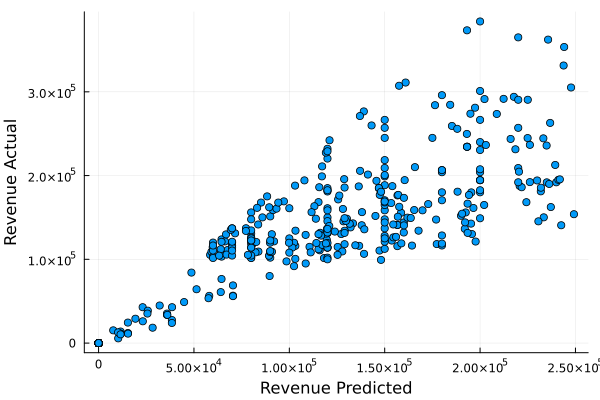

In [302]:
using Plots
#plot test_revenue_iai vs test_revenue_r
plot(test_revenue_iai, test_revenue_r, seriestype=:scatter, xlabel="Revenue Predicted", ylabel="Revenue Actual", legend=false)

In [303]:
#how many test_revenue_r are 0?
sum(test_revenue_r .== 0)

288